In [109]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
import sys
from iminuit import Minuit
from matplotlib.colors import ListedColormap
from tqdm import tqdm
import os
import itertools   

from ast import literal_eval

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.inspection import permutation_importance

# classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

In [3]:
sys.path.append('../External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH, simpson38
from ExternalFunctions import nice_string_output, add_text_to_ax 

In [4]:
COLOUR = ['#1E90FF', # 0 # Dodgerblue
          '#FFBF00', # 1 # Amber
          '#FF6347', # 2 # Tomato
          '#00A86B', # 3 # Jade
          '#8A2BE2', # 4 # Blueviolet
          '#FF6FFF', # 5 # Ultra Pink
          '#00CCFF', # 6 # Vivid Sky Blue
          '#00ff40', # 7 # Erin
          '#FF004F', # 8 # Folly
          '#0063A6', # 9 # Lapis Lazuli
        ]
def setMplParam(classNum):
    # Define effective colors, line styles, and markers based on the class number
   
    LINE = ['-', '-.', '--', '-.', ':','--','-.','-', ':', '--']
    MARKER = ['.','*', '^', 's', '.', 'p', 'o', 's', '.', 'd']
    COLOUR_EFF = COLOUR[:classNum]
    LINE_EFF = LINE[:classNum]
    MARKER_EFF = MARKER[:classNum]

    # Set the color cycle for lines including color, line style, and marker
    plt.rcParams['axes.prop_cycle'] = (plt.cycler(color=COLOUR_EFF) +
                                       plt.cycler(linestyle=LINE_EFF)+
                                       plt.cycler(marker=MARKER_EFF))

    # Set default line and marker sizes
    plt.rcParams['lines.markersize'] = 3  # Example size
    plt.rcParams['lines.linewidth'] = 2   # Example width for lines

    # Set label and title sizes
    plt.rcParams['axes.labelsize'] = 20
    plt.rcParams['axes.titlesize'] = 20

    # Set tick properties
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['xtick.labelsize'] = 20
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams['ytick.labelsize'] = 20

    # Set legend font size
    plt.rcParams['legend.fontsize'] = 12

    # Enable and configure grid
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.8
    plt.rcParams['grid.linestyle'] = '--'
    plt.rcParams['grid.linewidth'] = 1

    # Set axes line width
    plt.rcParams['axes.linewidth'] = 2

    # Set tick sizes and widths
    plt.rcParams['xtick.major.size'] = 7
    plt.rcParams['xtick.major.width'] = 3
    plt.rcParams['xtick.minor.size'] = 2
    plt.rcParams['xtick.minor.width'] = 2

    plt.rcParams['ytick.major.size'] = 7
    plt.rcParams['ytick.major.width'] = 3
    plt.rcParams['ytick.minor.size'] = 2
    plt.rcParams['ytick.minor.width'] = 2

setMplParam(10)


In [76]:
def readData():
    resource = 'resources/'
    data = pd.read_csv(resource+'prob1.csv', sep=' ', header=None)
    data.columns = ['first', 'second', 'third', 'fourth', 'fifth', 'sixth']
    return data
data = readData()

In [6]:
print(data.head())

      first    second  third    fourth     fifth     sixth
0  7.076218  0.083584    4.0  1.212479  2.470023  1.740495
1  6.182521  0.810306    4.0  1.151079  2.023988  7.642150
2  6.680523  0.857215    6.0  1.106831  1.136348 -0.798234
3  6.467101  0.222412    6.0  1.101607  2.469432  0.421692
4  6.320712  0.189092    4.0  1.111395  0.732828  1.676644


In [42]:
first_min = data['first'].min()
first_max = data['first'].max()

second_min = data['second'].min()
second_max = data['second'].max()

print(first_min, first_max)
print(second_min, second_max)

6.000117 10.995388
-0.102988 0.999965


In [7]:
def getHistoParam(data):
    Nbins = int(np.sqrt(data.shape[0])/4)
    counts, x_edges = np.histogram(data, bins=Nbins)
    binwidth = x_edges[1] - x_edges[0]
    x_centres = x_edges[:-1] + binwidth/2
    return Nbins, binwidth, counts, x_centres

In [8]:
def getHistoParamWithBinWidth(data, binwidth, isDensity = False):
    start_bin = np.floor(data.min()) - 0.5 * binwidth
    end_bin = np.ceil(data.max()) + 0.5 * binwidth
    bins = np.arange(start_bin, end_bin + binwidth, binwidth)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    counts, x_edges = np.histogram(data, bins=bins, density=isDensity)
    x_centres = x_edges[:-1] + binwidth/2
    return bins, counts, bin_centers, x_centres

In [9]:
def plotHisto(data, title):
    Nbin = int(np.sqrt(len(data))/4)
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.hist(data, bins=Nbin, histtype='step', label=title)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.set_title('Distribution of '+title)
    ax.legend()

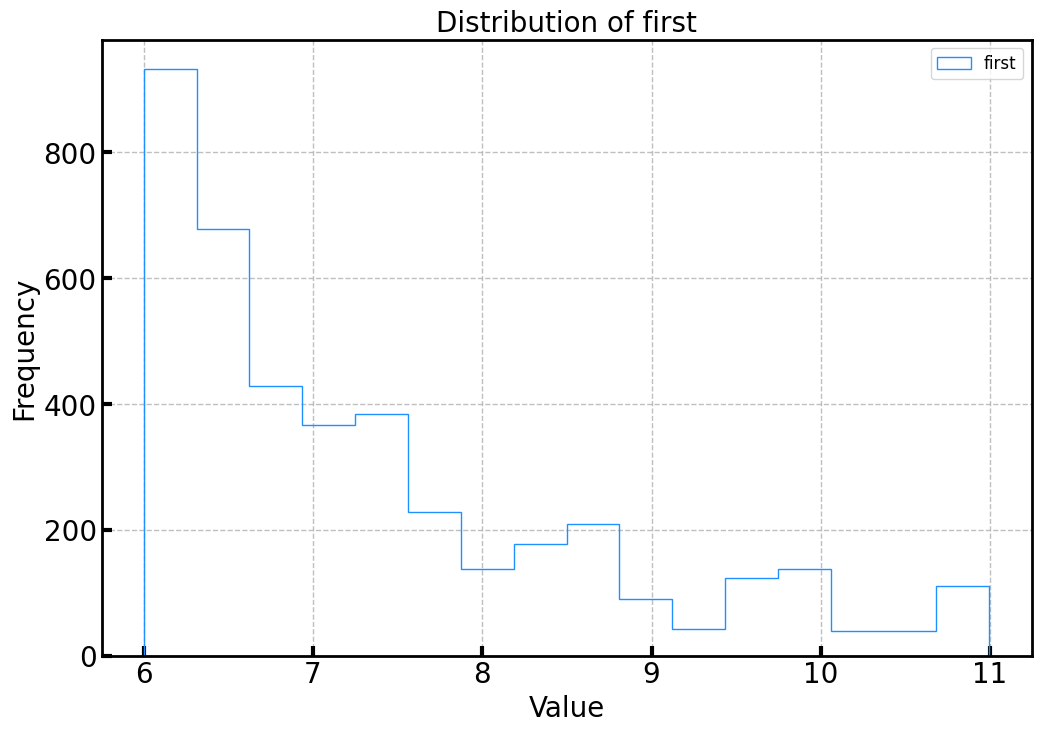

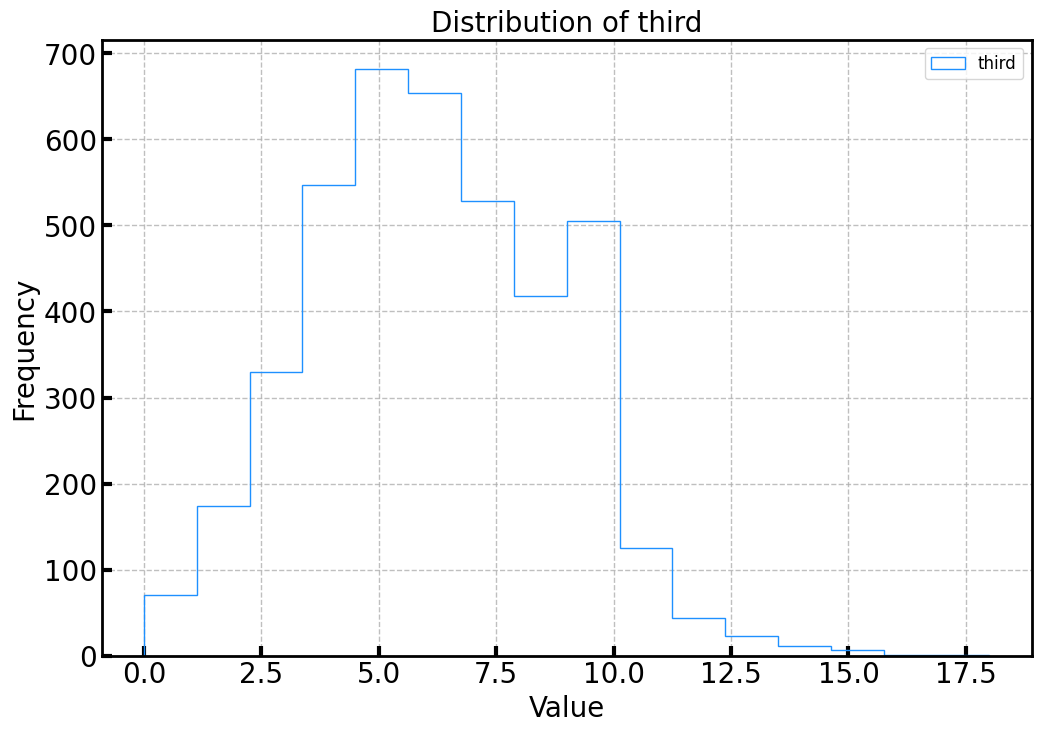

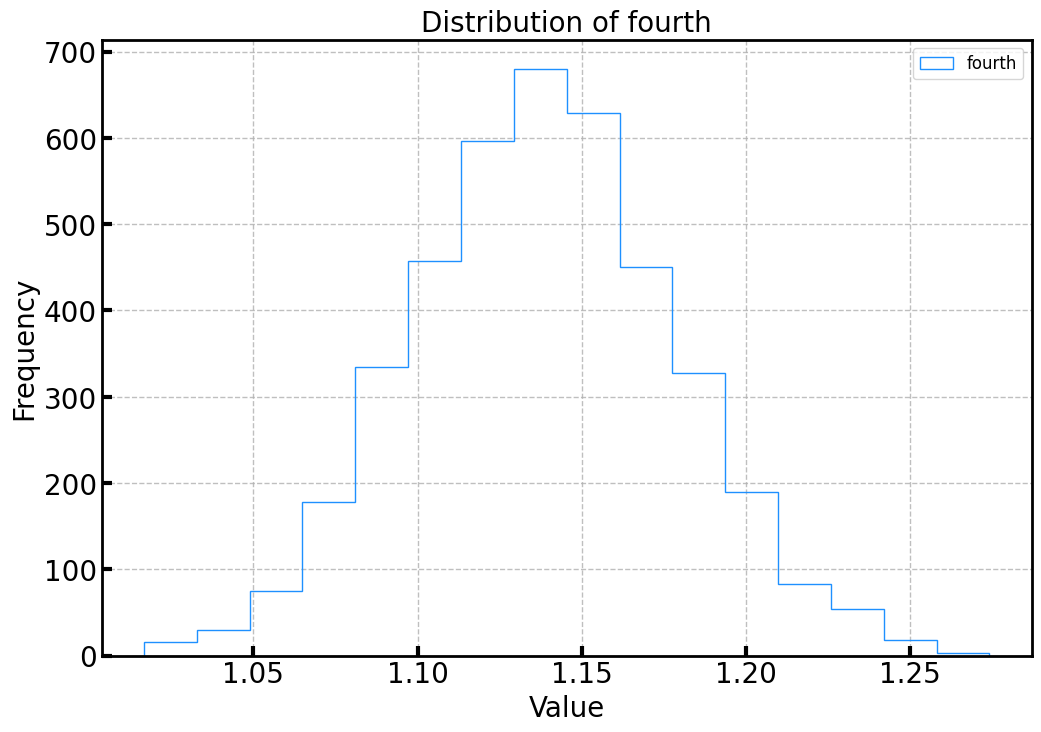

In [10]:
plotHisto(data['first'], 'first')
plotHisto(data['third'], 'third')
plotHisto(data['fourth'], 'fourth')

In [11]:
def f1(a):
    return lambda x: 1/(x + 5) * np.sin(a * x)
def f2(a):
    return lambda x: np.sin(a * x) + 1
def f3(a):
    return lambda x: np.sin(a * x**2)
def f4(a):
    return lambda x: np.sin((a * x + 1)**2)
def f5(a):
    return lambda x: x * np.tan(a * x)
def f6(a, b):
    return lambda x: 1 + a * x + b * x**2
def f7(a):
    return lambda x: 5 + a * x 
def f8(a, b, c):
    return lambda x: np.sin(a * x) + c*np.exp(b * x) + 1
def f9(a, b):
    return lambda x: np.exp(-(x - a)**2 / (2 * b**2))

In [12]:
def plotFunctions():
    x = np.linspace(-10, 10, 1000)
    
    a = 1
    b = 1
    c = 1
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(x, f1(a)(x), label='f1(x)')
    # ax.plot(x, f2(a)(x), label='f2(x)')
    # ax.plot(x, f3(a)(x), label='f3(x)')
    # ax.plot(x, f4(a)(x), label='f4(x)')
    # ax.plot(x, f5(a)(x), label='f5(x)')
    # ax.plot(x, f6(a, b)(x), label='f6(x)')
    # ax.plot(x, f7(a)(x), label='f7(x)')
    # ax.plot(x, f8(a, b, c)(x), label='f8(x)')
    # ax.plot(x, f9(a, b)(x), label='f9(x)')
    ax.set_xlabel('x')
    ax.set_ylabel('f(x)')
    ax.set_title('Functions')
    # ax.legend()
# plotFunctions()


In [13]:
def getArea(f, *args):
    np.random.seed(75)
    N = 10_000
    xmin = -10
    xmax = 10
    ymin = 0
    ymax = 1

    x = np.random.uniform(xmin, xmax, N)
    y = np.random.uniform(ymin, ymax, N)

    function_values = f(*args)(x)
    y = y[y < function_values]

    accepted = len(y)
    area = accepted / N * (xmax - xmin) * (ymax - ymin)
    return area

In [14]:
def getNormalised(f, *args):
    area = getArea(f, *args)
    return lambda x: f(*args)(x) / area

In [84]:
# normalised
# def binomial(n, p, k):
#     return np.math.comb(n, k) * p**k * (1-p)**(n-k)

def binomial(n, p, k):
    try:
        return np.math.comb(n, k) * p**k * (1-p)**(n-k)
    except ValueError:
        return 0

# normalised
def poisson(lam, k):
    return lam**k * np.exp(-lam) / np.math.factorial(k)

# normalised
def logarithmic(p, k):
    return (p**k) / (k * np.log(1-p))

In [71]:
def lnLLH(pdf, data):
    return -np.sum(np.log(pdf(data) + np.finfo(float).eps))

def lnLLH_discrete(distribution, params, data):
    llh = 0
    for k in data:
        k_int = int(k)
        probability = distribution(*params, k=k_int)
        llh += np.log(probability + np.finfo(float).eps)
    return -llh


In [17]:
def RasterScanCore(f, Nargs, data):
    a_range = np.linspace(-10, 10, 100)
    b_range = np.linspace(-10, 10, 100)
    c_range = np.linspace(4000, 8000, 100)

    min_llh = np.inf
    best_params = None

    if Nargs == 1:
        for a in a_range:
            pdf = getNormalised(f, a)
            llh = lnLLH(pdf, data)
            if llh < min_llh:
                min_llh = llh
                best_params = (a,)

    elif Nargs == 2:
        for a in a_range:
            for b in b_range:
                pdf = getNormalised(f, a, b)
                llh = lnLLH(pdf, data)
                if llh < min_llh:
                    min_llh = llh
                    best_params = (a, b)

    elif Nargs == 3:
        for a in a_range:
            for b in b_range:
                for c in c_range:
                    pdf = getNormalised(f, a, b, c)
                    llh = lnLLH(pdf, data)
                    if llh < min_llh:
                        min_llh = llh
                        best_params = (a, b, c)

    return min_llh, best_params

In [34]:
def compareAcrossColumns(data):
    continuous_functions = [f1, f2, f3, f4, f5, f6, f7, f9]
    continuous_Nargs = [1, 1, 1, 1, 1, 2, 1, 2]
    
    results = []
    
    for column in data.columns:
        for func, nargs in zip(continuous_functions, continuous_Nargs):
            min_llh, best_params = RasterScanCore(func, nargs, data[column])
            func_name = func.__name__
            
            results.append({
                'Column': column,
                'Function': func_name,
                'LLH': min_llh,
                'Parameters': best_params
            })
    
    results_df = pd.DataFrame(results)
    return results_df

# function_results = compareAcrossColumns(data)


In [44]:
def findMinumumLLHfunction(results):
    best_functions = results.groupby('Column').apply(lambda x: x.loc[x['LLH'].idxmin()])
    return best_functions

In [68]:
def RasterScanCoreAdjusted(f, Nargs, data, data_min, data_max):
    a_range = np.linspace(data_min, data_max, 100) if Nargs >= 1 else None
    b_range = np.linspace(data_min - 5, data_max + 5, 100) if Nargs >= 2 else None
    c_range = np.linspace(data_min, data_max, 100) if Nargs == 3 else None

    min_llh = np.inf
    best_params = None

    for a in a_range if a_range is not None else [None]:
        for b in b_range if b_range is not None else [None]:
            for c in c_range if c_range is not None else [None]:
                params = (a, b, c)[:Nargs]
                pdf = f(*params) if params[0] is not None else f()
                llh = lnLLH(pdf, data)
                if llh < min_llh:
                    min_llh = llh
                    best_params = params

    return min_llh, best_params

In [67]:
def compareAcrossColumnsAdjusted(data):
    continuous_functions = [f1, f2, f3, f4, f5, f6, f7, f9]
    continuous_Nargs = [1, 1, 1, 1, 1, 2, 1, 2]
    
    results = []
    for column in data.columns:
        if column == 'first':
            xmin, xmax = 6.000117, 10.995388
        elif column == 'second':
            xmin, xmax = -0.102988, 0.999965
        else:
            xmin, xmax = -10, 10

        for func, nargs in zip(continuous_functions, continuous_Nargs):
            min_llh, best_params = RasterScanCoreAdjusted(func, nargs, data[column], xmin, xmax)
            func_name = func.__name__

            results.append({
                'Column': column,
                'Function': func_name,
                'LLH': min_llh,
                'Parameters': best_params
            })
    
    results_df = pd.DataFrame(results)
    return results_df

In [69]:
function_results = compareAcrossColumnsAdjusted(data)

c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [86]:
best_functions = findMinumumLLHfunction(function_results)

In [80]:
def RasterScan_discrete(distribution, param_ranges, data):
    best_llh = np.inf
    best_params = None
    for params in itertools.product(*param_ranges.values()):
        llh = lnLLH_discrete(distribution, params, data)
        if llh < best_llh: 
            best_llh = llh
            best_params = params
    return best_llh, best_params

In [81]:
def RasterScanShell(data):
    binomial_ranges = {'n': range(1, 21), 'p': np.linspace(0.1, 0.9, 9)}
    poisson_ranges = {'lam': np.linspace(1, 10, 10)}
    logarithmic_ranges = {'p': np.linspace(0.1, 0.9, 9)}

    binomial_llh, binomial_params = RasterScan_discrete(binomial, binomial_ranges, data)
    poisson_llh, poisson_params = RasterScan_discrete(poisson, poisson_ranges, data)
    logarithmic_llh, logarithmic_params = RasterScan_discrete(logarithmic, logarithmic_ranges, data)

    print(f"Binomial Best LLH: {binomial_llh}, Params: {binomial_params}")
    print(f"Poisson Best LLH: {poisson_llh}, Params: {poisson_params}")
    print(f"Logarithmic Best LLH: {logarithmic_llh}, Params: {logarithmic_params}")

In [83]:
RasterScanShell(data['third'])

C:\Users\yhjo7\AppData\Local\Temp\ipykernel_8704\3514173664.py:7: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return np.math.comb(n, k) * p**k * (1-p)**(n-k)
C:\Users\yhjo7\AppData\Local\Temp\ipykernel_8704\3514173664.py:13: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return lam**k * np.exp(-lam) / np.math.factorial(k)
C:\Users\yhjo7\AppData\Local\Temp\ipykernel_8704\163009602.py:9: RuntimeWarning: invalid value encountered in log
  llh += np.log(probability + np.finfo(float).eps)  # Add epsilon to avoid log(0)
C:\Users\yhjo7\AppData\Local\Temp\ipykernel_8704\3514173664.py:17: RuntimeWarning: divide by zero encountered in scalar divide
  return (p**k) / (k * np.log(1-p))


Binomial Best LLH: 9768.268614809149, Params: (20, 0.30000000000000004)
Poisson Best LLH: 9570.106126739776, Params: (6.0,)
Logarithmic Best LLH: inf, Params: None


In [90]:
functions_dict = {
    'f1': f1,
    'f2': f2,
    'f3': f3,
    'f4': f4,
    'f5': f5,
    'f6': f6,
    'f7': f7,
    'f9': f9,
}

In [112]:
def getNormalised(f, *args):
    x_range = np.linspace(-10, 10, 10000)
    y_values = f(*args)(x_range)
    area = np.trapz(y_values, x_range)
    return lambda x: f(*args)(x) / area

In [105]:
def getNormalisedBestFunction(data, column, function_name, param_str):
    params = literal_eval(param_str)
    function = functions_dict[function_name]
    pdf = getNormalised(function, *params)
    return pdf

In [113]:
def plotDataWithFits(data, best_functions):
    Nbins = 20
    for column in data.columns:
        params_str = best_functions.loc[column]['Parameters']
        function_name = best_functions.loc[column]['Function']
        
        pdf = getNormalisedBestFunction(data, column, function_name, params_str)
        
        x = np.linspace(data[column].min(), data[column].max(), 1000)
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.hist(data[column], bins=Nbins, density=True, histtype='step', label=column)
        ax.plot(x, pdf(x), label='Best Fit')
        ax.set_xlabel('Value')
        ax.set_ylabel('Density')
        ax.set_title('Normalised Distribution and Best Fit for ' + column)
        ax.legend()
        plt.show()

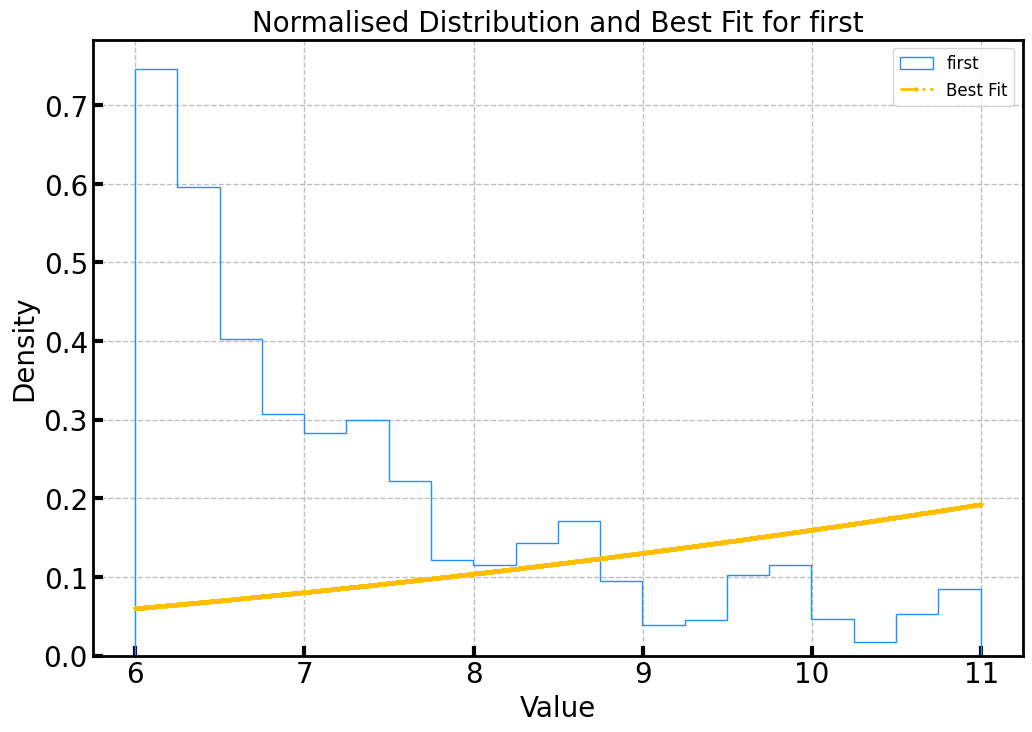

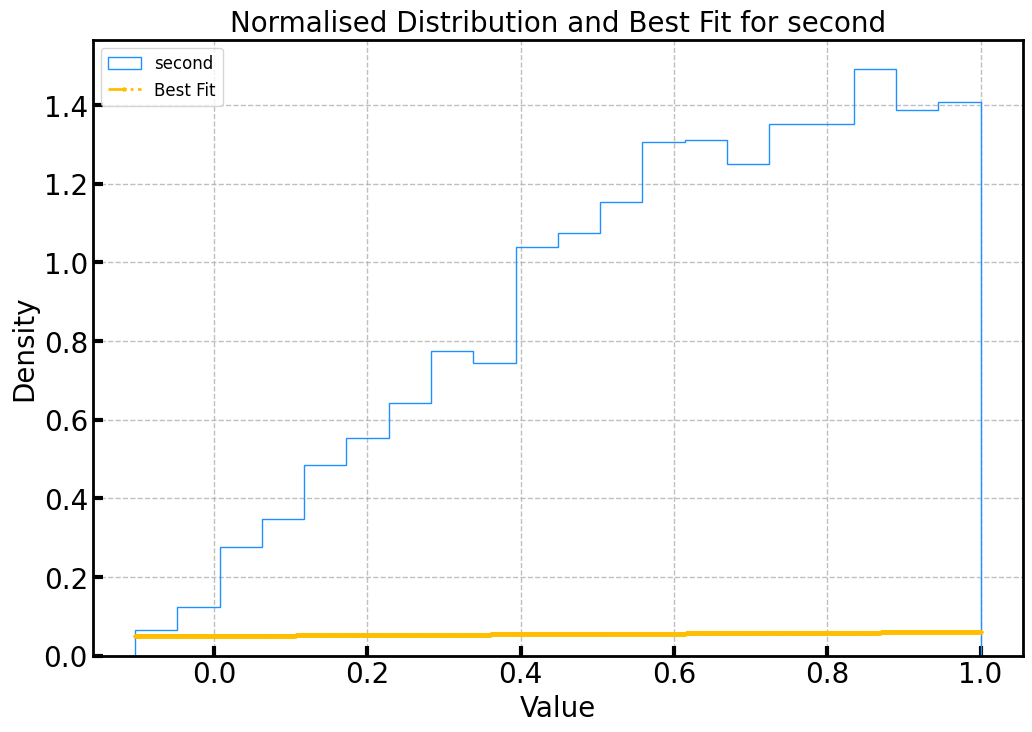

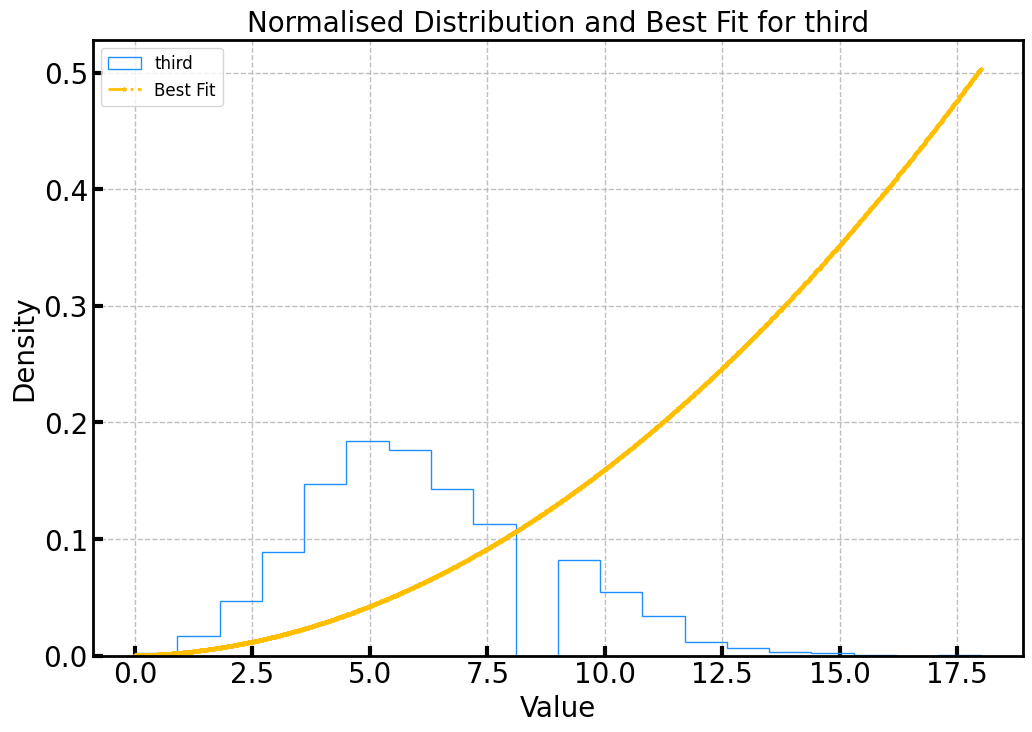

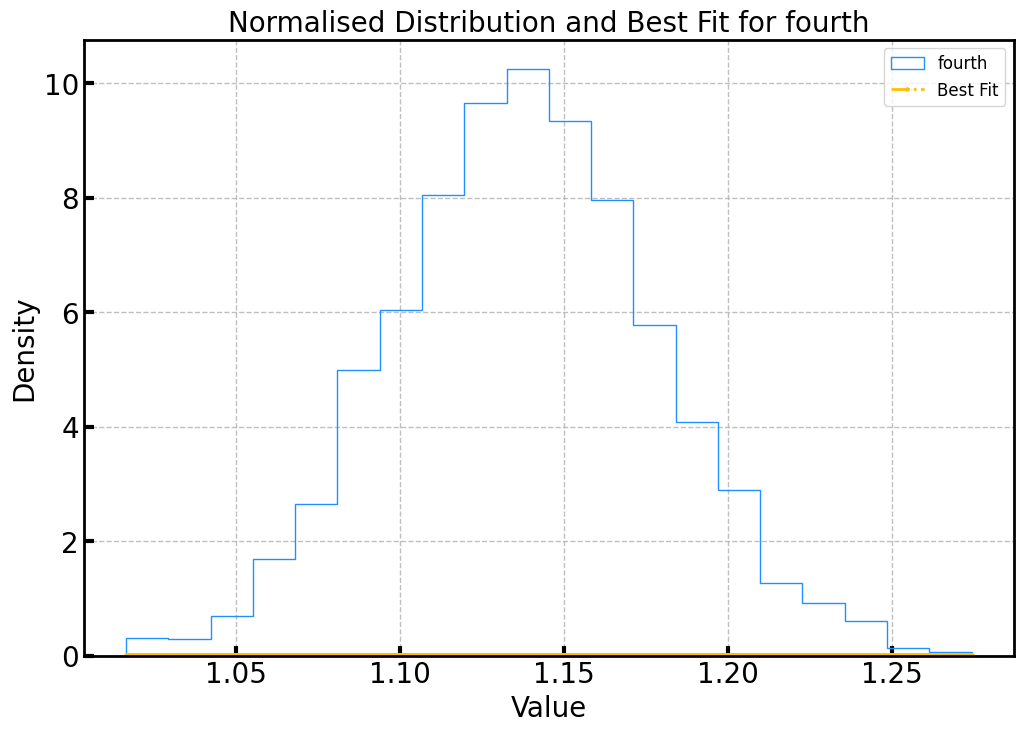

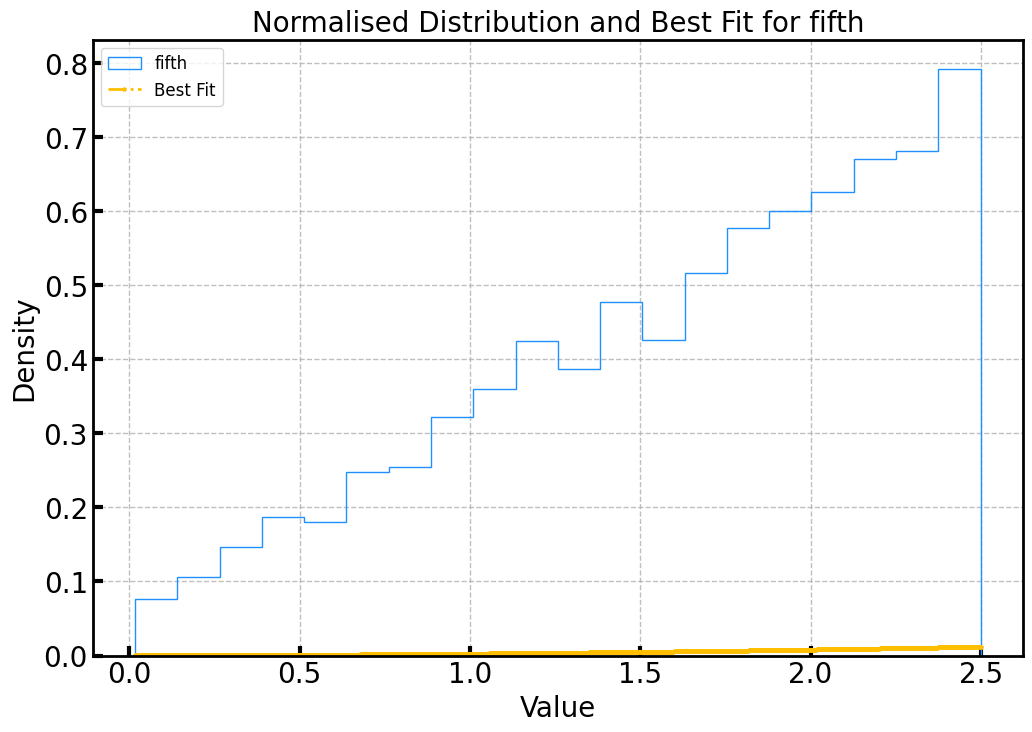

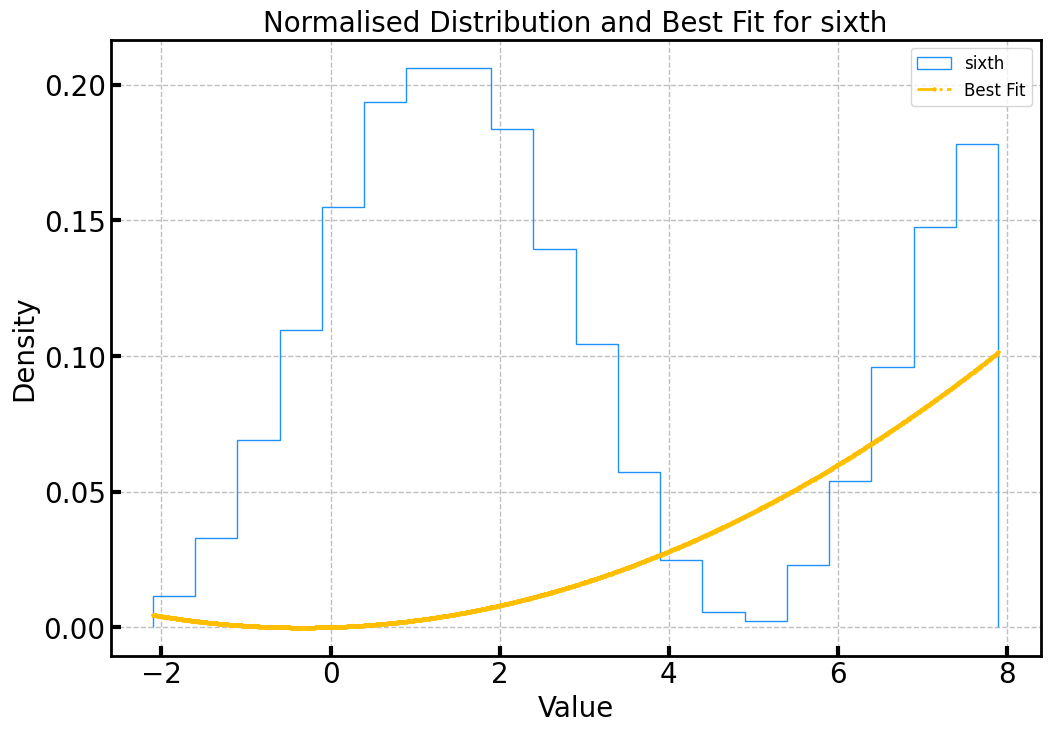

In [114]:
plotDataWithFits(data, best_functions)